In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

INFO:sklearn.datasets._california_housing:Downloading Cal. housing from https://ndownloader.figshare.com/files/5976036 to /home/ubuntu/scikit_learn_data


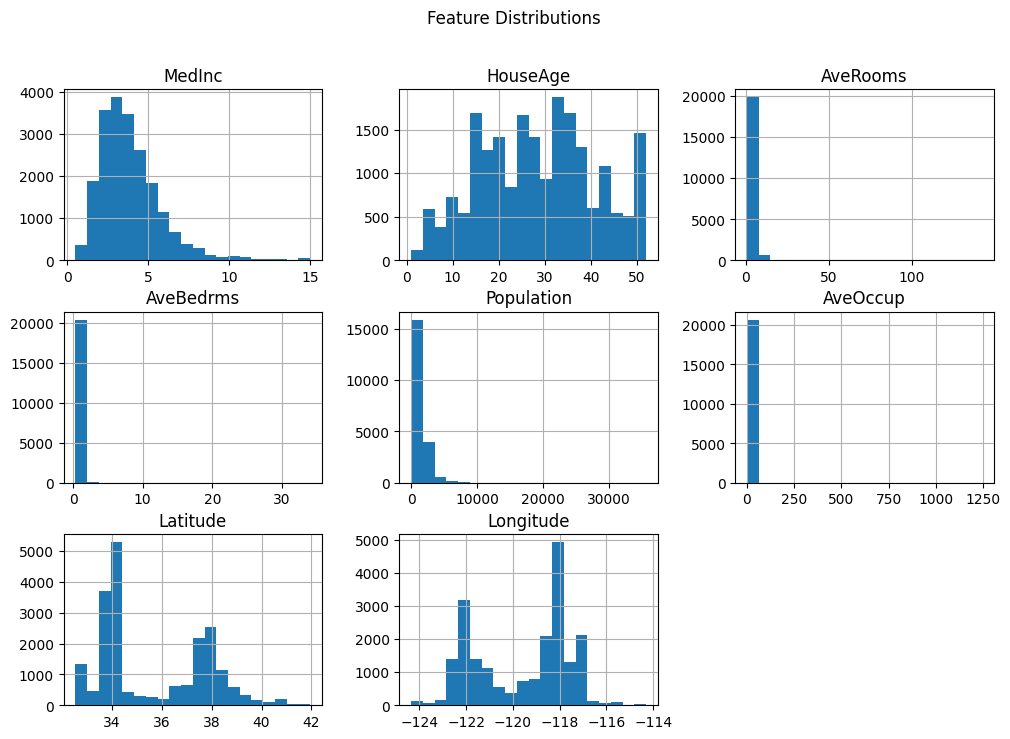

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

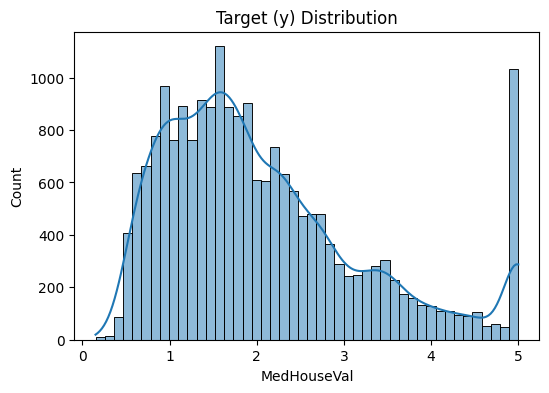

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

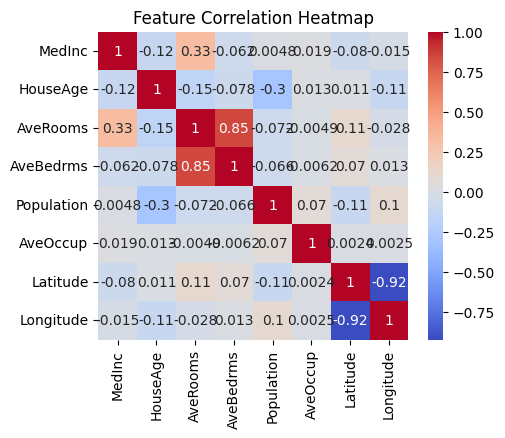

In [7]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=8, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=8)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.631141                 1.523197             1.872641   
1                  1.456873                 1.565426             1.792163   
2                  1.859663                 1.650804             1.785922   
3                  1.863192                 1.604685             1.891584   
4                  1.400577                 1.697899             1.903869   
5                  1.412851                 1.884571             1.877892   
6                  1.863850                 1.627771             1.618472   
7                  1.946829                 1.555964             1.863645   
mean               1.679372                 1.638790             1.825773   
std                0.230668                 0.113977             0.094467   

      DefaultBART_Rhat_RMSE  
0                  2.354871  
1                  1.541121  
2                  1.627511

In [10]:
rhat_df.to_csv("results/real3_CalHousing_rhat.csv", index=False)

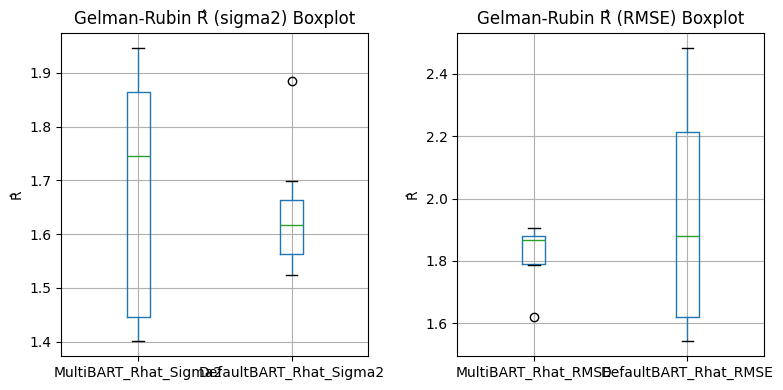

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

INFO:2025-11-24 19:56:29,261:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-11-24 19:56:30,652:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-11-24 19:56:34,739:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to op

test_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.217606  0.227396  0.284304  0.272079  0.218599
1      0.222062  0.229586  0.289723  0.261053  0.217833
2      0.222863  0.229362  0.291681  0.262780  0.226877
3      0.207926  0.210265  0.273101  0.244411  0.213037
4      0.218961  0.226079  0.277798  0.265762  0.223567
5      0.215526  0.225612  0.278017  0.255995  0.223564
6      0.220293  0.230346  0.285769  0.266244  0.228732
7      0.214742  0.225994  0.292375  0.272201  0.226946
mean   0.217497  0.225580  0.284096  0.262566  0.222394
std    0.004821  0.006452  0.007152  0.009120  0.005431



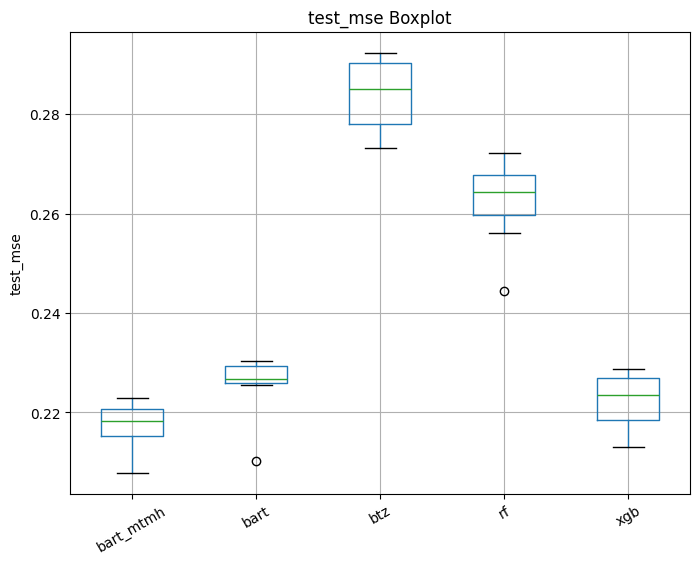

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.152411  0.179189  0.264529  0.036415  0.070528
1      0.156593  0.182271  0.259645  0.036316  0.071458
2      0.147548  0.177391  0.255192  0.035701  0.067329
3      0.160247  0.181675  0.259378  0.036102  0.072052
4      0.152215  0.181423  0.256472  0.034991  0.072937
5      0.145376  0.176424  0.258121  0.036173  0.067958
6      0.151477  0.178812  0.255568  0.035879  0.070881
7      0.150620  0.175064  0.257327  0.036122  0.072070
mean   0.152061  0.179031  0.258279  0.035962  0.070652
std    0.004708  0.002633  0.003005  0.000453  0.002007



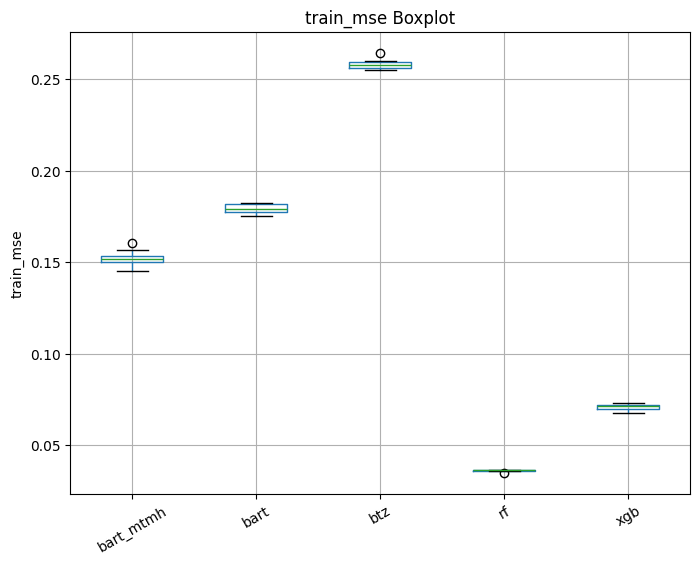

pi_length:
      bart_mtmh      bart       btz
0      1.593817  1.720490  2.167352
1      1.603764  1.735530  2.180833
2      1.594358  1.715999  2.147395
3      1.623513  1.724085  2.167478
4      1.600767  1.722514  2.163253
5      1.561545  1.698403  2.166379
6      1.595364  1.710799  2.162880
7      1.590769  1.703085  2.150283
mean   1.595487  1.716363  2.163232
std    0.017156  0.012023  0.010511



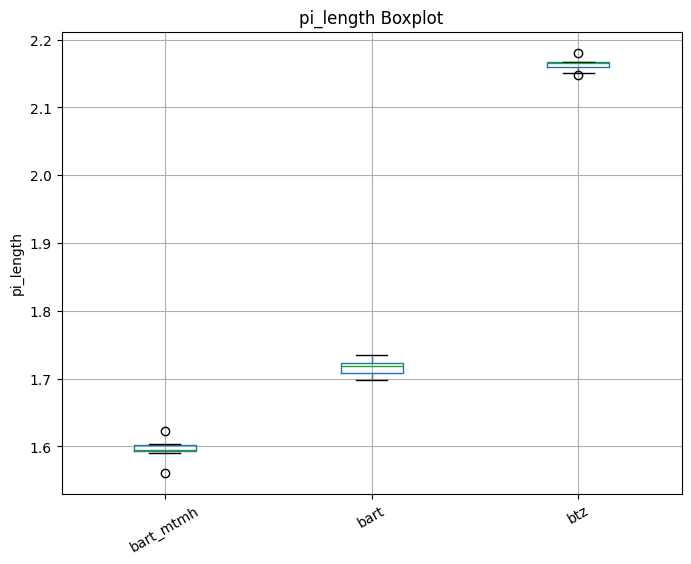

coverage:
      bart_mtmh      bart       btz
0      0.925969  0.934302  0.950000
1      0.926163  0.935465  0.948837
2      0.927907  0.936822  0.945930
3      0.932752  0.939535  0.949612
4      0.931977  0.935271  0.953101
5      0.918798  0.927713  0.947481
6      0.925969  0.938178  0.948062
7      0.925388  0.930620  0.943798
mean   0.926865  0.934738  0.948353
std    0.004330  0.003900  0.002791



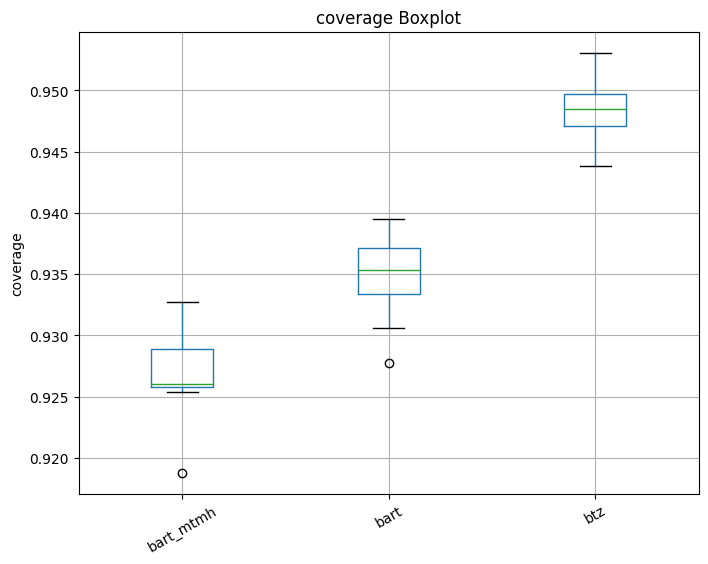

train_time:
       bart_mtmh        bart         btz         rf       xgb
0     745.727212   92.765146  154.443135  17.318648  0.376419
1     748.780757   94.290400  153.408229  16.469485  0.373313
2     740.564427   91.739281  151.013481  19.838459  0.354102
3     743.062021   90.625870  150.631425  19.514846  0.465879
4     747.756913   91.374455  154.419329  16.996052  0.339478
5     744.739143   93.039660  154.142850  17.730148  0.340263
6     761.472846  103.890392  143.118927  15.833579  0.381812
7     749.877867   95.327633  154.041051  16.414057  0.367894
mean  747.747648   94.131605  151.902303  17.514409  0.374895
std     6.332155    4.231927    3.858315   1.458196  0.040117



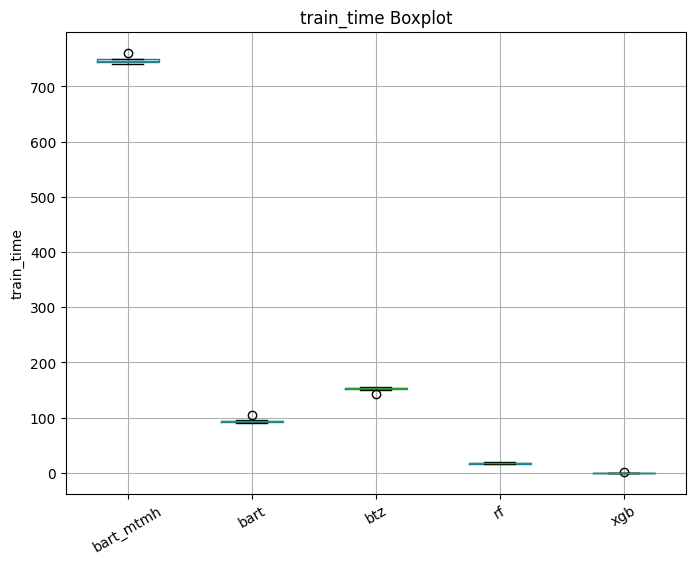

In [12]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=8, n_skip=1000, n_post=1000, n_trees=100, n_jobs=8)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [13]:
for k, v in mse_results.items():
    csv_name = f"results/real3_CalHousing_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real3_CalHousing_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 20, 50],
    n_runs=8, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=8
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real3_CalHousing_tries.csv", index=False)

In [17]:
import pandas as pd
df = pd.read_csv("results/real3_CalHousing_tries.csv")
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage   Train_Time
0            1     1.701998   1.693491  0.227047  0.934205   161.560961
1            5     1.666559   1.696100  0.218061  0.929797   443.805530
2           10     1.679372   1.825773  0.217732  0.928900   751.325349
3           20     1.563413   1.652091  0.217017  0.926478  1336.173508
4           50     1.528264   1.699694  0.215172  0.924516  3036.265250
